# Methods for finding the scaling factor

This notebook compares different methods of finding the scaling factor to be applied to the single-dish data. uv-samples where the interometer-ed image and single-dish image overlap are compared.

In [93]:
# ipython notebook setup:
%matplotlib inline

In [94]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))

In [95]:
import image_registration
from astropy import convolution
import numpy as np
from uvcombine.uvcombine import feather_compare
from uvcombine.scale_factor import find_effSDbeam
# from uvcombine.tests.utils import generate_test_fits

In [96]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
imsize = 1024
im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)

In [97]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [98]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [99]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [100]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
lowresfwhm = 30
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())

In [101]:
# make some headers for HDUs
pixel_scale = 1 * u.arcsec
beamfwhm = lowresfwhm * u.arcsec
restfreq = (2 * u.mm).to(u.Hz, u.spectral())
header = {'CDELT1': -(pixel_scale).to(u.deg).value,
              'CDELT2': (pixel_scale).to(u.deg).value,
              'BMAJ': beamfwhm.to(u.deg).value,
              'BMIN': beamfwhm.to(u.deg).value,
              'BPA': 0.0,
              'CRPIX1': imsize/2.,
              'CRPIX2': imsize/2.,
              'CRVAL1': 0.0,
              'CRVAL2': 0.0,
              'CTYPE1': 'GLON-CAR',
              'CTYPE2': 'GLAT-CAR',
              'CUNIT1': 'deg',
              'CUNIT2': 'deg',
              'CRVAL3': restfreq.to(u.Hz).value,
              'CUNIT3': 'Hz',
              'CDELT3': 1e6, # 1 MHz; doesn't matter
              'CRPIX3': 1,
              'CTYPE3': 'FREQ',
              'RESTFRQ': restfreq.to(u.Hz).value,
              'BUNIT': 'MJy/sr',
             }
header = fits.Header(header)

interf_header = header.copy()
interf_fwhm = smallest_scale * u.arcsec
interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
interf_header["BMIN"] = interf_fwhm.to(u.deg).value

Check the effects of assuming the wrong single-dish FWHM when calculating the scale factor. From [](), the ratios will have a quadratic dependence of the wavenumber when the wrong FWHM is used.

In [102]:
interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)

# Sample a large range of FWHMs
lowresfwhms = np.arange(18, 46, 0.25) * u.arcsec

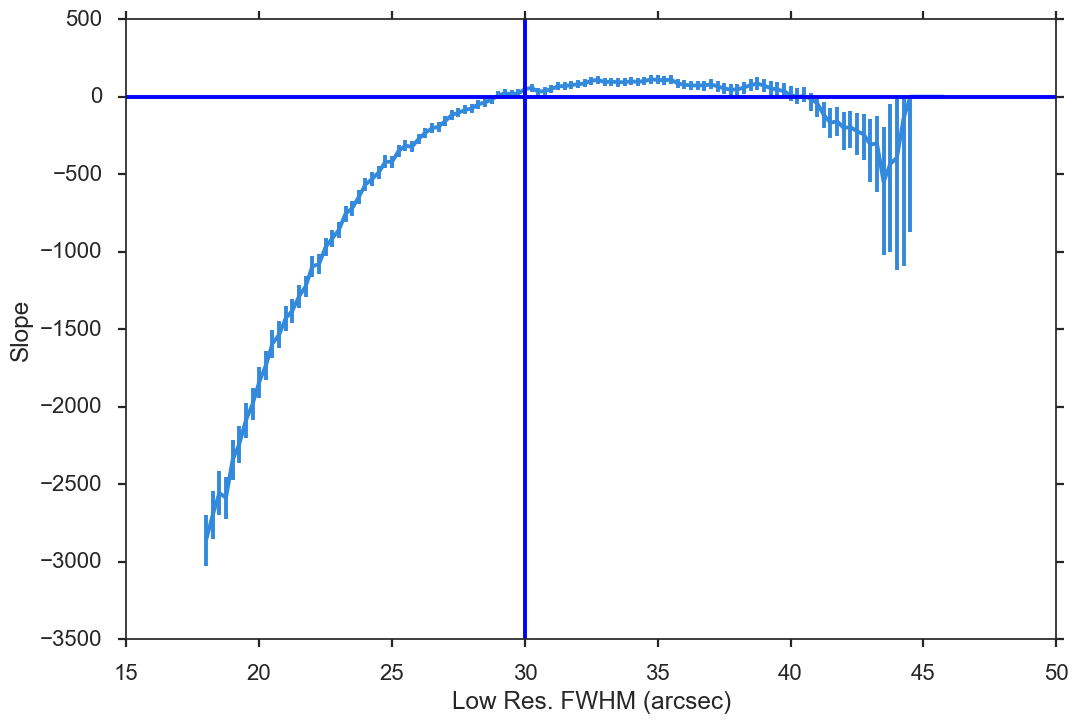

In [103]:
slopes, slopes_CI = \
    find_effSDbeam(interferometer_hdu, singledish_hdu, largest_scale * u.arcsec, lowresfwhms,
                   verbose=True)
pl.axvline(30)

The behaviour is close to quadratic, as expected. The approximation breaks down above the actual FWHM. The curve flattens out in this regime, so overestimating the FWHM is equally as bad for a large range.

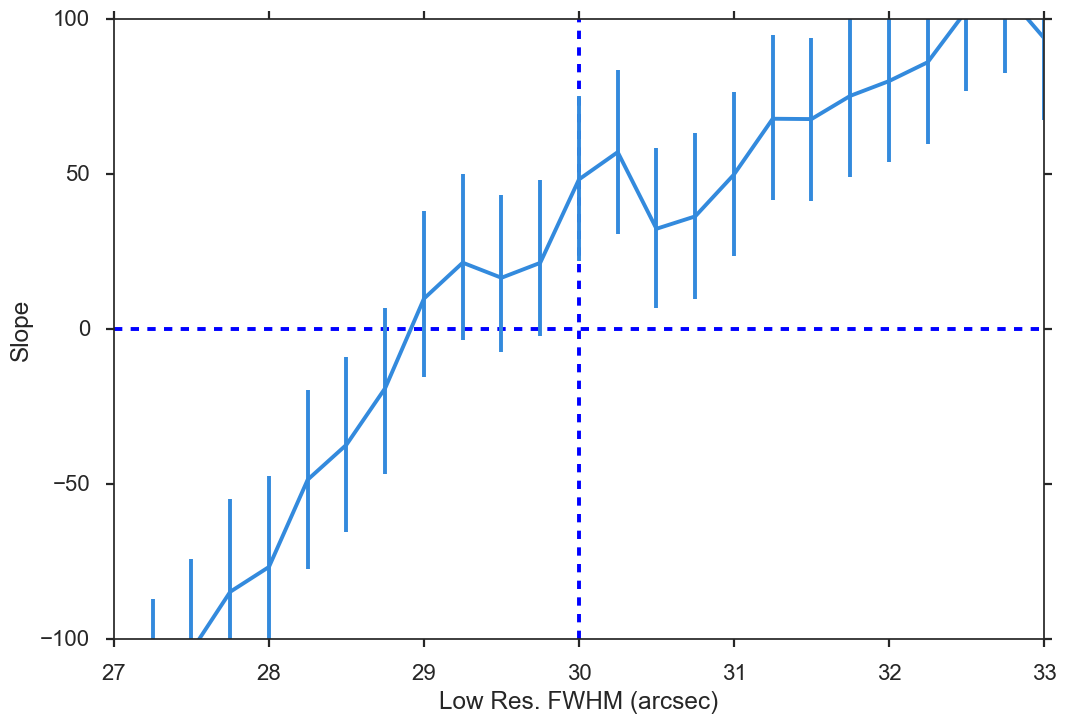

In [104]:
pl.errorbar(lowresfwhms.to(u.arcsec).value, slopes,
            yerr=[slopes - slopes_CI[0],
                  slopes_CI[1] - slopes])

pl.ylabel("Slope")
pl.xlabel("Low Res. FWHM (arcsec)")
pl.xlim([27, 33])
pl.ylim([-100, 100])
pl.axvline(30, linestyle='--', zorder=-1)
pl.axhline(0, linestyle='--', zorder=-1)

The slope is consistent with 0 at a FWHM just below the actual FWHM.

In [107]:
from scipy import interpolate

yToFind = 0
yreduced = slopes - yToFind
freduced = interpolate.UnivariateSpline(lowresfwhms.value, yreduced, s=1e5)
freduced.roots()

array([ 29.05970878,  40.13257091,  44.85118811,  45.6337948 ])

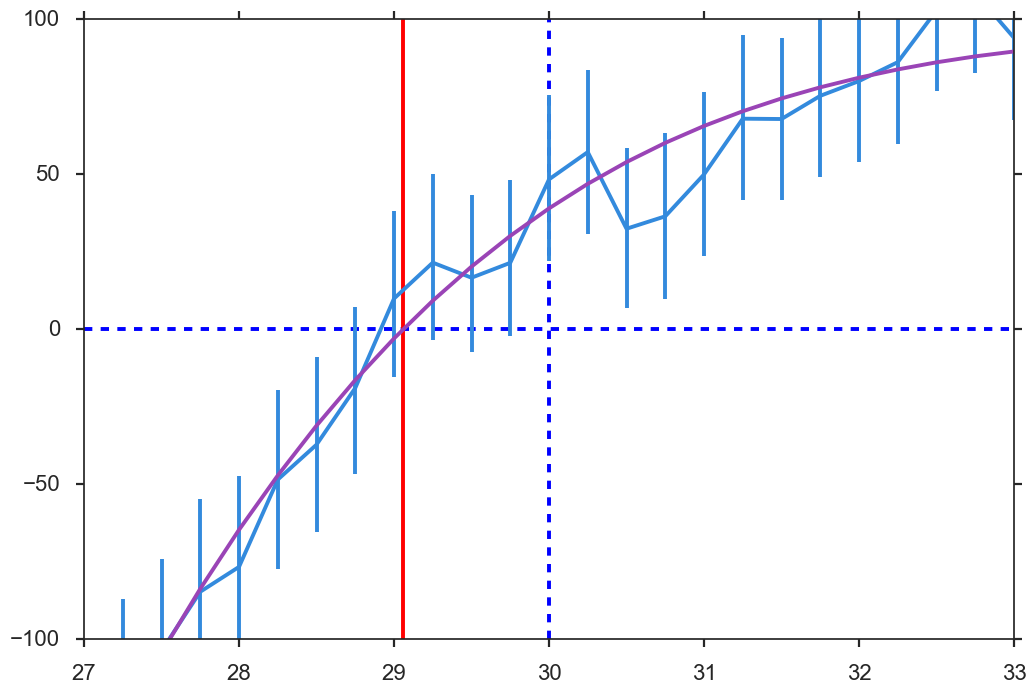

In [108]:
pl.errorbar(lowresfwhms.to(u.arcsec).value, slopes,
            yerr=[slopes - slopes_CI[0],
                  slopes_CI[1] - slopes])
pl.plot(lowresfwhms.value, freduced(lowresfwhms.value))
pl.xlim([27, 33])
pl.ylim([-100, 100])
pl.axvline(30, linestyle='--', zorder=-1)
pl.axhline(0, linestyle='--', zorder=-1)
# Closest spline root to the FWHM
pl.axvline(freduced.roots()[0], linestyle="-", color='r', zorder=-1)

This method returns a good approximation to the true FWHM, so long as you have a well-defined range where you already know where to look.